In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from scipy.optimize import minimize

In [2]:
%matplotlib notebook

In [3]:
NaD_blue = 5889.95
NaD_red = 5895.92
z = 0.0094

In [4]:
filename = '../data/spectra/ZTF19adcecwu_20200118_MMT_v1.ascii'
spec_df = pd.read_csv(filename, comment='#', delim_whitespace=True, header=None)

wv = spec_df[0].values
fl = spec_df[1].values

<IPython.core.display.Javascript object>


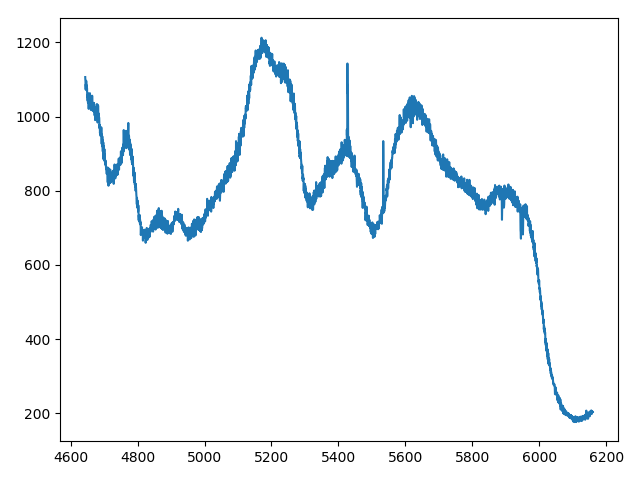

In [5]:
plt.figure()
plt.plot(wv, fl)
plt.tight_layout()

### Make a figure showing the Na D feature

In [6]:
flux_plot = np.repeat(fl, 2)
wv_plot = wv.copy()
wv_plot[:-1] += np.diff(wv)/2
wv_plot = np.append(wv[0]-(wv[1]-wv[0])/2, np.append(np.repeat(wv_plot[0:-1], 2), wv[-1]+(wv[-1]-wv[-2])/2))

In [7]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c*((lambda_rf/lambda_0)**2 - 1)/((lambda_rf/lambda_0)**2 + 1)
    
    return v

vel_ngc4441 = velocity_rf(wv_plot/(1+z), NaD_red)

vel_mw = velocity_rf(wv_plot, NaD_red)

v_sdss = velocity_rf(NaD_red/(1+z), NaD_red/(1+0.00888))

#### Fit and remove  a continuum

In [8]:
def lnlike(theta, t, m):
    
    p0, p1, p2 = theta
    
    model = p0 + p1*t + p2*t**2 #+ p3*t**3 + p4*t**4
    
    lnl = -0.5*np.sum((m - model)**2)
    
    return lnl

def neg_lnlike(theta, t, m):
    return -1*lnlike(theta, t, m)

<IPython.core.display.Javascript object>


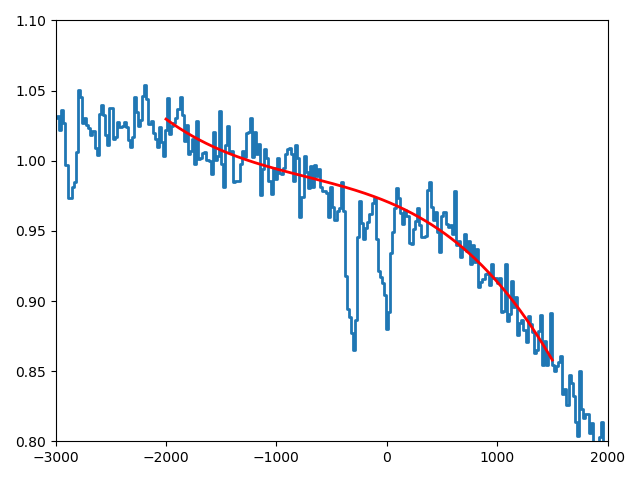

In [9]:
near_NaD = np.where(((vel_ngc4441 > -2000) & 
                     (vel_ngc4441 < -440)) | 
                    ((vel_ngc4441 > 140) & 
                     (vel_ngc4441 < 1500)))

plt.figure()
plt.plot(vel_ngc4441, flux_plot/775, 
          lw=2)
v_grid = np.linspace(-2000,1500,1000)
theta = (0.95, -5e-5,  1e-8)

z_ngc4441 = np.polyfit(vel_ngc4441[near_NaD][::2], flux_plot[near_NaD][::2], 3)
p_ngc4441 = np.poly1d(z_ngc4441)
plt.plot(v_grid, p_ngc4441(v_grid)/775, 'red', lw=2) 


plt.xlim(-3000,2000)
plt.ylim(0.8,1.1)
plt.tight_layout()

<IPython.core.display.Javascript object>


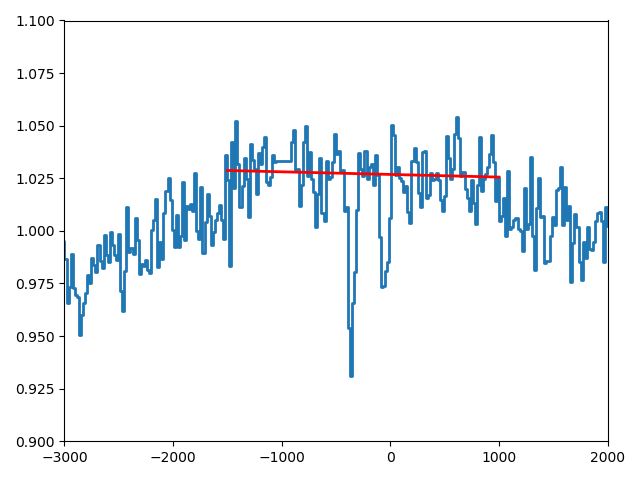

In [10]:
near_NaD = np.where(((vel_mw > -1500) & 
                     (vel_mw < -500)) | 
                    ((vel_mw > 80) & 
                     (vel_mw < 1000)))

plt.figure()
plt.plot(vel_mw, flux_plot/775, 
         lw=2)
v_grid = np.linspace(-1500,1000,1000)
theta = (0.95, -5e-5,  1e-8)

z_mw = np.polyfit(vel_mw[near_NaD][::2], flux_plot[near_NaD][::2], 1)
p_mw = np.poly1d(z_mw)
plt.plot(v_grid, p_mw(v_grid)/775, 'red', lw=2) 


plt.xlim(-3000,2000)
plt.ylim(0.9,1.1)
plt.tight_layout()

In [11]:
v_sdss

-154.48011951935396

In [12]:
ax.text?

Object `ax.text` not found.


<IPython.core.display.Javascript object>


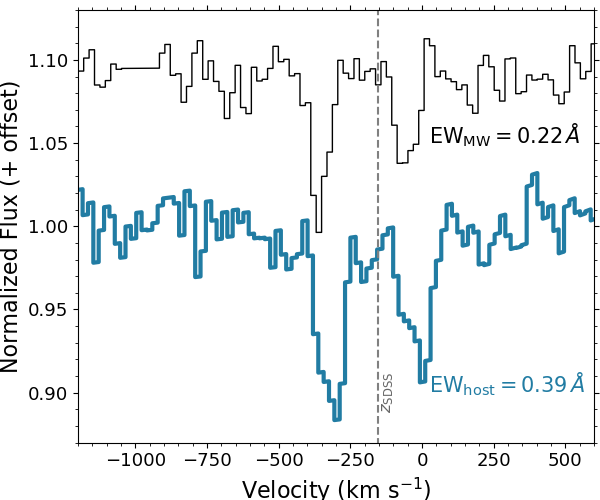

In [33]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(vel_ngc4441, flux_plot/p_ngc4441(vel_ngc4441), 
        color = aam_colors['blue'], lw=3)

ax.plot(vel_mw, flux_plot/p_mw(vel_mw)+0.09, 
        color = 'k', lw=1)

ax.plot([v_sdss,v_sdss], [-1e6, 1e6],  '0.5', ls='--')
ax.text(v_sdss+10, 0.9, r'$z_\mathrm{SDSS}$', rotation=90,
        color='0.4', va='center',ha='left', fontsize=12)

ax.set_xlim(-1200,600)
ax.set_ylim(0.87,1.13)
ax.set_ylabel('Normalized Flux (+ offset)',fontsize=16)
ax.set_xlabel(r'Velocity (km s$^{-1}$)', fontsize=16)
ax.tick_params(which='both', top=True,right=True, labelsize=13)

ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.xaxis.set_major_locator(MultipleLocator(250))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))

ax.text(25, 0.9, 
        r'$\mathrm{EW}_\mathrm{host} = 0.39 \,\AA$',
        color=aam_colors['blue'],fontsize=15)

ax.text(25, 1.05, 
        r'$\mathrm{EW}_\mathrm{MW} = 0.22 \,\AA$',
        color='k',fontsize=15)

# red_line = ax.twiny()
# red_line.set_xlabel(r'Velocity (km s$^{-1}$)', fontsize=13)
# red_line.set_xlim((np.array(ax.get_xlim())/(1+z)-NaD_red)/NaD_red*2.9979e5)

fig.subplots_adjust(left=0.13,right=0.99,top=0.98,bottom=0.115)
fig.savefig('../paper/figures/NaD.pdf')

Some notes on these absorption lines:

For the MW component - Gaussian EW = -0.20 and Moment EW = -0.2129

D2: 0.116, 0.110, 0.122, 0.121, 0.119 >> 0.118 +/- 4%
D1: 0.086, 0.083, 0.089, 0.093, 0.091 >> 0.088 +/- 4%
Total: 0.216, 0.228, 0.192, 0.209, 0.214 >> 0.221 +/ 6%; 0.220, 0.226, 0.142, 0.178, 0.218 >> 0.20 +/ 18%

For the NGC 4441 Na D

D2: 0.237, 0.220, 0.218, 0.252, 0.232 >> 0.231 +/- 6%
D1: 0.177, 0.181, 0.180, 0.168, 0.174 >> 0.176 +/- 3%
Total: 0.447, 0.389, 0.365, 0.387, 0.385 >> 0.395 +/- 8%; 0.518, 0.403, 0.370, 0.409, 0.478 >> 0.44 +/14%

In [14]:
ew = [0.216, 0.228, 0.192, 0.209, 0.214]
print(np.mean(ew))
print(np.std(ew, ddof=1)/np.mean(ew))

0.2118
0.061776873404329094


Notes on reddening:

SF11 = E(B-V) = 0.018 >> total E(B-V) = 0.05 from relative strength of Na D

Poz12:
MW
D2: 0.022
D1: 0.028
Total: 0.026


NGC 4441
D2: 0.038
D1: 0.047
Total: 0.041